# 粒子フィルタで Lorenz 96 model の双子実験

Lorenz 96 model は1996年にEdward Lorenzが提案した非線形モデルである．
\\[(\forall i\in\{1,\cdots,N\})\quad\frac{dx_i}{dt}=(x_{i+1}-x_{i-2})x_{i-1}-x_i+F\\]
ここで，周期境界条件$x_{-1}=x_{N-1},x_0=x_N,x_{N+1}=x_1$を採用している．<br>
参照：https://en.wikipedia.org/wiki/Lorenz_96_model

In [1]:
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# update
def Lorenz96_update(x, dt, N, F) :
    d = np.zeros(N)
    # first the 3 edge cases : i = 1,2,N
    d[0] = x[0] + dt * ((x[1] - x[N - 2]) * x[N - 1] - x[0])
    d[1] = x[1] + dt * ((x[2] - x[N - 1]) * x[0] - x[1])
    d[N - 1] = x[N - 1] + dt * ((x[0] - x[N - 3]) * x[N - 2] - x[N - 1])
    for i in range(2, N - 1) :
        d[i] = x[i] + dt * ((x[i + 1] - x[i - 2]) * x[i - 1] - x[i])
    d = d + dt * F
    return d

# perfect simulation function
def Lorenz96_perfect(initial_x, time, dt, N, F) :
    t = 0
    x = initial_x
    l = math.ceil(time / dt) + 1
    d = np.zeros((l + 1, N))
    d[0] = initial_x
    for i in range(l) :
        x = Lorenz96_update(x, dt, N, F)
        d[i + 1] = x
    return d

# perfect simulation function with noise
def Lorenz96_perfect_noise(initial_x, time, dt, N, F, sigma) :
    t = 0
    x = initial_x
    l = math.ceil(time / dt) + 1
    d = np.zeros((l + 1, N))
    d[0] = initial_x
    for i in range(l) :
        noise = rd.normal(0, sigma, size = N)
        x = Lorenz96_update(x, dt, N, F) + noise
        d[i + 1] = x
    return d

# initial particle
def Initial_particle(mu_0, initial_sd, n_particle) :
    return rd.normal(mu_0, initial_sd, size = n_particle)

## 粒子フィルタ

In [59]:
class ParticleFilter(object):
    '''
    y [dim, time]: observation data
    n_dim : dimension of data
    n_particle : number of particles which use PF
    mu_0 [dim]: mu for initial normal distribution
    sigma_0 : sigma for initial normal distribution
    obs_sigma : variance of observation noise
    sys_sigma : variance of system noise
    initial_sd : sd for initial normal distribution
    F : Lorenz parameter F (forcing constant)
    dt : devision scale of time
    
    '''
    def __init__(self, y, n_dim = 30, n_particle = 1000, obs_sigma = 0.01, sys_sigma = 0.01,
                 mu_0 = 5.0 * np.ones(30), initial_sd = 0.1, F = 8, dt = 0.01):
        self.y = y
        self.n_dim = n_dim
        self.n_particle = n_particle
        self.obs_sigma = obs_sigma
        self.sys_sigma = sys_sigma
        self.mu_0 = mu_0
        self.initial_sd = initial_sd
        self.F = F
        self.dt = dt
        self.log_likelihood = - np.inf
    
    # likelihood for normal distribution
    def norm_likelihood(self, y, x, s2):
        return (np.sqrt(2 * np.pi * s2))**(-1) * np.exp(-np.dot(y - x, y - x) / (2 * s2))
    
    # log likelihood for normal distribution
    def log_norm_likelihood(self, y, x, s2) :
        return -np.dot(y - x, y - x) / (2 * s2)

    def F_inv(self, w_cumsum, idx, u):
            if np.any(w_cumsum < u) == False:
                return 0
            k = np.max(idx[w_cumsum < u])
            return k + 1
        
    def resampling(self, weights):
        w_cumsum = np.cumsum(weights)
        # make label array
        idx = np.asanyarray(range(self.n_particle))
        # save index label k
        k_list = np.zeros(self.n_particle, dtype = np.int32)
        
        # get resampling index response to normal weight
        for i, u in enumerate(rd.uniform(0, 1, size = self.n_particle)):
            k = self.F_inv(w_cumsum, idx, u)
            k_list[i] = k
        return k_list

    def resampling2(self, weights):
        """
        stratified resampling
        """
        idx = np.asanyarray(range(self.n_particle))
        u0 = rd.uniform(0, 1 / self.n_particle)
        u = [1 / self.n_particle*i + u0 for i in range(self.n_particle)]
        w_cumsum = np.cumsum(weights)
        k = np.asanyarray([self.F_inv(w_cumsum, idx, val) for val in u])
        return k
    
    def simulate(self, seed = 71):
        '''
        T : length of y
        x [time, dim, particle]: prediction distribution particles
        x_resampled [time, dim, particle]: filter distribution particles
        initial_x [dim, particle]: initial distribution of x
        w [time, particle]: weight lambda of each particle
        log_w [time, particle] : log weight w
        w_normed [time, particle]: normed weitht beta of each particle
        l [time]: log likelihood for each time
        v : system noise particles
        k : index number for resampling
        '''
        rd.seed(seed)

        # number of time-series data
        T = len(self.y)
        
        # initial filter, prediction
        x = np.zeros((T + 1, self.n_dim, self.n_particle))
        x_resampled = np.zeros((T + 1, self.n_dim, self.n_particle))
        
        # initial x
        for dim in range(self.n_dim) :
            initial_x = Initial_particle(self.mu_0[dim], self.initial_sd, self.n_particle)
            x_resampled[0, dim] = initial_x
            x[0, dim] = initial_x

        # weight
        w        = np.zeros((T, self.n_particle))
        # because of memory saving, use w as w, log_w
        #log_w    = np.zeros((T, self.n_particle))
        w_normed = np.zeros((T, self.n_particle))

        #l = np.zeros(T) # 時刻毎の尤度

        for t in range(T):
            print("\r calculating... t={}".format(t), end="")
            for i in range(self.n_particle):
                #  normal trend model
                v = rd.normal(0, np.sqrt(self.sys_sigma), size = self.n_dim) # System Noise
                x[t + 1, :, i] = Lorenz96_update(x_resampled[t, :, i], self.dt, self.n_dim, self.F) + v
            if (not any(np.isnan(self.y[t]))) :
                for i in range(self.n_particle) :
                    # likelihood for each particle for y[t]
                    #w[t, i] = self.norm_likelihood(self.y[t], x[t + 1, :, i], self.obs_sigma)
                    #log_w[t, i] = self.log_norm_likelihood(self.y[t], x[t + 1, :, i], self.obs_sigma)
                    w[t, i] = self.log_norm_likelihood(self.y[t], x[t + 1, :, i], self.obs_sigma)
                # normalization
                #log_w[t] = log_w[t] - np.mean(log_w[t])
                w[t] = w[t] - np.mean(w[t])
                #w[t] = np.exp(log_w[t])
                w[t] = np.exp(w[t])
                w_normed[t] = w[t] / np.sum(w[t])
                # likelihood for each time
                #l[t] = np.log(np.sum(w[t]))

                # Resampling
                #k = self.resampling(w_normed[t]) # resampling
                k = self.resampling2(w_normed[t]) # resampling
                #print(x[t+1,:,k].shape)
                #print(x_resampled[t+1].shape)
                x_resampled[t + 1] = x[t + 1, :, k].T
            else :
                x_resampled[t + 1] = x[t + 1]
            
        # overall likelihood
        #self.log_likelihood = np.sum(l) - T * np.log(n_particle)
        
        self.x = x
        self.x_resampled = x_resampled
        self.w = w
        self.w_normed = w_normed
        #self.l = l
        
    def get_filtered_value(self, dim):
        #for i in range(n_dim) :
        #    filter_state[i] = np.diag(np.dot(self.w_normed, self.x[1:, i, :].T))
        return np.mean(self.x[1:, dim, :], axis = 1)
    
    def get_filtered_value_all(self):
        #for i in range(n_dim) :
        #    filter_state[i] = np.diag(np.dot(self.w_normed, self.x[1:, i, :].T))
        return np.mean(self.x[1:, :, :], axis = 2)

## 双子実験

双子実験：決定論的シミュレーションによって得られたデータを観測値とし，<br>
どれぐらいデータ同化による予測が一致しているか確認する手法．<br>
カオス系のLorenzモデルがよく用いられる．

In [35]:
# parameter
# n_dim = N
N = 30
n_particle = 10**3
# sys_sigma, obs_sigma are variance
sys_sigma = 0.027
obs_sigma = 2.615
# make sigma is standard deviation
make_sigma = 0.0001
initial = 5.0 * np.ones(N)
mu_0 = 4.9 * np.ones(N)
initial_sd = 0.01
F = 8
dt = 0.01
time = 15.0

In [36]:
# perfect simulation
perf_x = Lorenz96_perfect(initial, time, dt, N, F)
# perfect simulation + noise
perf_x_noise = Lorenz96_perfect_noise(initial, time, dt, N, F, make_sigma)

In [25]:
perf_x[::10]

array([[ 5.        ,  5.        ,  5.        , ...,  5.        ,
         5.        ,  5.        ],
       [ 5.28685377,  5.28685377,  5.28685377, ...,  5.28685377,
         5.28685377,  5.28685377],
       [ 5.54627919,  5.54627919,  5.54627919, ...,  5.54627919,
         5.54627919,  5.54627919],
       ..., 
       [ 7.99999896,  7.99999896,  7.99999896, ...,  7.99999896,
         7.99999896,  7.99999896],
       [ 7.99999906,  7.99999906,  7.99999906, ...,  7.99999906,
         7.99999906,  7.99999906],
       [ 7.99999915,  7.99999915,  7.99999915, ...,  7.99999915,
         7.99999915,  7.99999915]])

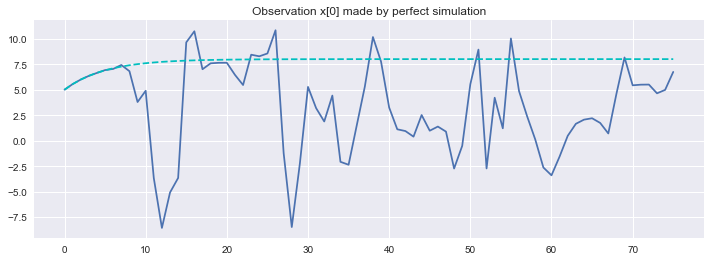

In [37]:
# plot observation from perfect simulation data
time_interval = 20
time_step = math.ceil(time / dt) + 1
time_data = np.linspace(0, time, time_step)
obs_x = np.zeros((time_step, N))
obs_x[:, :] = np.nan
obs_x[::time_interval] = perf_x_noise[::time_interval]
plt.figure(figsize = (12, 4))
plt.plot(obs_x[::time_interval, 0], label = 'obs_u')
plt.plot(perf_x[::time_interval, 0], linestyle = '--', color = 'c', label = 'perf_u')
plt.title("Observation x[0] made by perfect simulation")
plt.show()

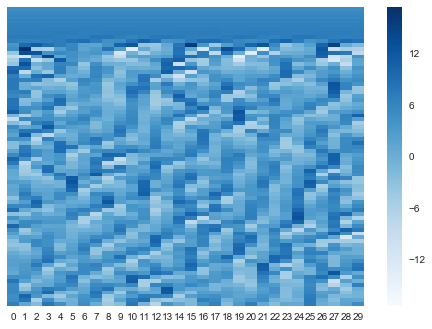

In [49]:
# heat map
sns.heatmap(data = obs_x[::time_interval], cmap = 'Blues', yticklabels = False)
plt.show()

In [60]:
pf = ParticleFilter(obs_x, N, n_particle, obs_sigma, sys_sigma, mu_0, initial_sd, F, dt)
pf.simulate()

 calculating... t=1500

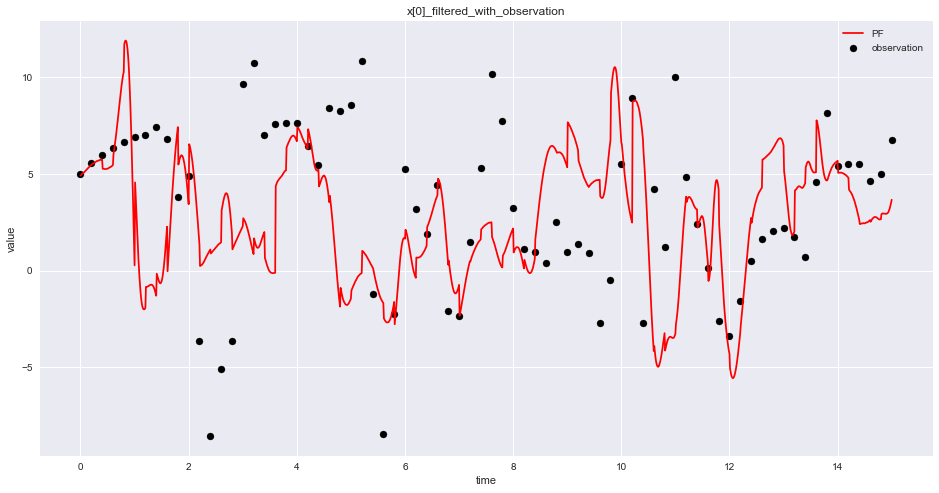

In [61]:
T = len(obs_x)
        
plt.figure(figsize=(16,8))
plt.scatter(time_data[::time_interval], obs_x[::time_interval, 0], color = "k", marker = 'o', label = "observation")
plt.plot(time_data, pf.get_filtered_value(0), color = "r", label = "PF")
        
#for t in range(T):
#    plt.scatter(np.ones(self.n_particle)*t, self.x[t], color = "r", s = 2, alpha = 0.1)
        
plt.legend(loc = 'best')
plt.xlabel('time')
plt.ylabel('value')
plt.title("x[0]_filtered_with_observation")
plt.savefig("plot/171113_Lorenz96_twin_experiment_PF_x0.png")
plt.show()

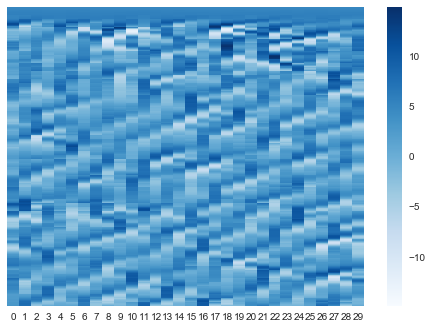

In [63]:
# heat map
sns.heatmap(pf.get_filtered_value_all(), cmap = 'Blues', yticklabels = False)
plt.savefig('plot/171113_Lorenz96_PF_heatmap.png')
plt.show()

なんか遷移してるっぽい？

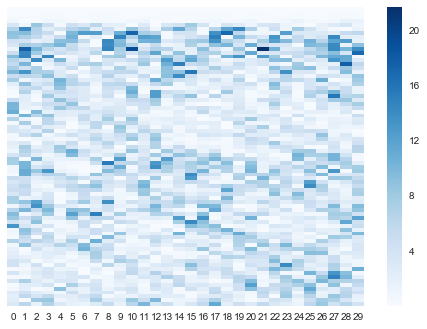

In [65]:
# heatmap of error
error = obs_x[::time_interval] - pf.get_filtered_value_all()[::time_interval]
error = np.sqrt(error * error)
sns.heatmap(error, cmap = 'Blues', yticklabels = False)
plt.savefig('plot/171113_Lorenz96_PF_error_heatmap.png')
plt.show()

## 無香料カルマンフィルター

無香料カルマンフィルタ（UKF）に関して<br>
pykalman，https://pykalman.github.io <br>
西山清，http://www.ieice-hbkb.org/files/01/01gun_05hen_06m.pdf <br>
Qitta，https://qiita.com/g_rej55/items/618778dbb4bf286a985b

In [72]:
# prepare for transition_functions, observation_functions
def transition_functions(state, noise) :
    dt = 0.01
    time_interval = 20
    N = 30
    F = 8
    for i in range(time_interval) :
        state = Lorenz96_update(state, dt, N, F) + noise
    return state

def observation_functions(state, noise) :
    return state + noise

In [74]:
def transition_functions_add(state) :
    dt = 0.01
    time_interval = 20
    N = 30
    F = 8
    for i in range(time_interval) :
        state = Lorenz96_update(state, dt, N, F)
    return state

def observation_functions_add(state) :
    return state

In [78]:
from pykalman import UnscentedKalmanFilter
#from pykalman import AdditiveUnscentedKalmanFilter
#kf = KalmanFilter(transition_matrices = np.array([[1, 1], [0, 1]]),
#                  transition_covariance = 0.0000001*np.eye(2))
ukf = UnscentedKalmanFilter(initial_state_mean = mu_0, initial_state_covariance = initial_sd * np.eye(N),
                  transition_functions = transition_functions,
                  observation_functions = observation_functions,
                  transition_covariance = sys_sigma * np.eye(N),
                  observation_covariance = obs_sigma * np.eye(N))
'''
ukf = AdditiveUnscentedKalmanFilter(initial_state_mean = mu_0, initial_state_covariance = initial_sd * np.eye(N),
                  transition_functions = transition_functions_add,
                  observation_functions = observation_functions_add,
                  transition_covariance = sys_sigma * np.eye(N),
                  observation_covariance = obs_sigma * np.eye(N))
                  '''

unscented_kalman_filter_x = ukf.filter(obs_x[::time_interval])[0]
print(unscented_kalman_filter_x[::time_interval])

plt.figure(figsize=(16, 8))
plt.scatter(time_data[::time_interval], obs_x[::time_interval, 0], marker = "o", label="observations")
plt.plot(time_data[::time_interval], unscented_kalman_filter_x[:, 0], "r", label="UKF")
#plt.axhline(x, color="k", label="truth value")
plt.legend(loc = 'best')
plt.title('Unscented Kalman Filter')
plt.savefig('plot/171113_unscented_kalman_filter_Lorenz96_x0.png')
plt.show()

LinAlgError: 3-th leading minor not positive definite

3-th leading minor not positive definite (正定値でないのが3つある)というエラーが出てしまう．<br>
中村先生に相談